# OpenPIV tutorial 1


In this tutorial we read the pair of images using `imread`, compare them visually 
and process using OpenPIV. Here the import is using directly the basic functions and methods

In [1]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2 # Added for image equalozation
from math import *
import imageio
import skimage.exposure as exposure
import skimage.morphology as morphology
from skimage.filters import rank

folder = '/home/edo20/PIV'

In [2]:
# Experimental data

# Camera
resolution = (992,1004) #pixel
physical_window = (45,45) # m
pixel_depth = 8 # bit
dynamic_range = 2**pixel_depth # levels
scaling_factor = 1/(np.mean(physical_window)/np.mean(resolution)) # m/pixel
image_number = '052'

In [3]:
frame_a  = tools.imread( folder + '/Images/A' + image_number + 'a.tif' )
frame_b  = tools.imread( folder + '/Images/A' + image_number + 'b.tif' )

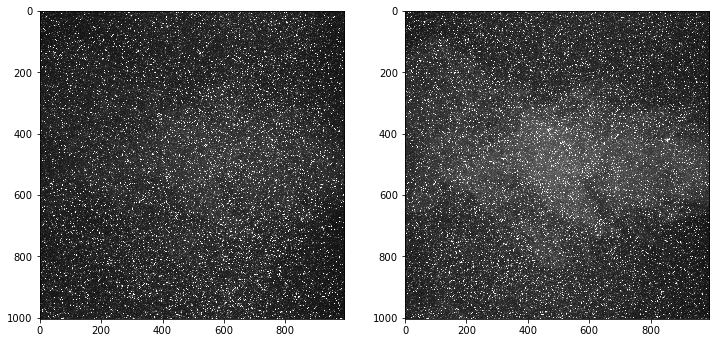

In [4]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [5]:
# Image equalization
def image_equalization(frame,dynamic_range,plot=0):
    frame = np.array(frame)
    # Histogram and cdf of the original image
    hist,bins = np.histogram(frame.flatten(),dynamic_range,[0,dynamic_range])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    
    #Image equalization
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    frameEQ = cdf[frame]    
    
    # Histogram and cdf of the equalized image
    frameEQ = np.array(frameEQ)
    histEQ,binsEQ = np.histogram(frameEQ.flatten(),dynamic_range,[0,dynamic_range])
    cdfEQ = histEQ.cumsum()
    cdf_normalizedEQ = cdfEQ * histEQ.max()/ cdfEQ.max()
    
    # Plot
    if plot:
        # Oriinal image
        ax1 = plt.subplot(1,2,1)
        ax1.plot(cdf_normalized, color = 'b')
        ax1.hist(frame.flatten(),dynamic_range,[0,dynamic_range], color = 'r')
        ax1.set_xlim([0,dynamic_range])
        ax1.legend(('cdf','histogram'), loc = 'upper left')
        ax1.set_title('Original image')
        # Equalized image
        ax2 = plt.subplot(1,2,2)
        ax2.plot(cdf_normalizedEQ, color = 'b')
        ax2.hist(frameEQ.flatten(),dynamic_range,[0,dynamic_range], color = 'r')
        ax2.set_xlim([0,dynamic_range])
        ax2.legend(('cdf','histogram'), loc = 'upper left')
        ax2.set_title('Equalized image')
        plt.show()
        
    return frameEQ

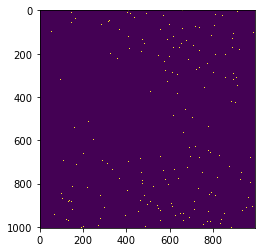

In [6]:
# Put a random noise where the image is saturated
index = (frame_a==255) * (frame_b==255)
plt.imshow(index)

In [7]:
#frame_a = image_equalization(frame_a,dynamic_range,plot=1)

In [8]:
#frame_b = image_equalization(frame_b,dynamic_range,plot=1)

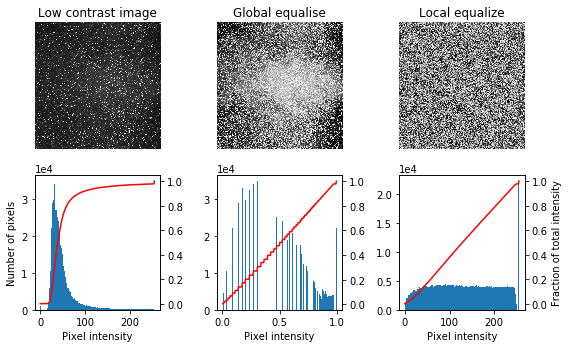

In [9]:
if True:
    def plot_img_and_hist(image, axes, bins=256):
        """Plot an image along with its histogram and cumulative histogram.

        """
        ax_img, ax_hist = axes
        ax_cdf = ax_hist.twinx()

        # Display image
        ax_img.imshow(image, cmap=plt.cm.gray)
        ax_img.set_axis_off()

        # Display histogram
        ax_hist.hist(image.ravel(), bins=bins)
        ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
        ax_hist.set_xlabel('Pixel intensity')

        # Display cumulative distribution
        img_cdf, bins = exposure.cumulative_distribution(image, bins)
        ax_cdf.plot(bins, img_cdf, 'r')

        return ax_img, ax_hist, ax_cdf


    # Load an example image
    img = frame_a

    # Global equalize
    img_rescale = exposure.equalize_hist(img)

    # Equalization
    selem = morphology.disk(70)
    img_eq = rank.equalize(img, selem=selem)


    # Display results
    fig = plt.figure(figsize=(8, 5))
    axes = np.zeros((2, 3), dtype=np.object)
    axes[0, 0] = plt.subplot(2, 3, 1)
    axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
    axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
    axes[1, 0] = plt.subplot(2, 3, 4)
    axes[1, 1] = plt.subplot(2, 3, 5)
    axes[1, 2] = plt.subplot(2, 3, 6)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast image')
    ax_hist.set_ylabel('Number of pixels')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
    ax_img.set_title('Global equalise')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
    ax_img.set_title('Local equalize')
    ax_cdf.set_ylabel('Fraction of total intensity')


    # prevent overlap of y-axis labels
    fig.tight_layout()


In [10]:
frame_a = rank.equalize(frame_a, selem=selem)
frame_b = rank.equalize(frame_b, selem=selem)

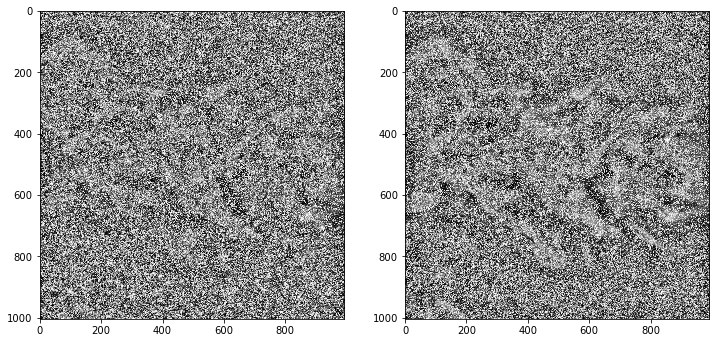

In [11]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [12]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 40  # pixels, search in image B
overlap = 16 # pixels, 50% overlap
dt = 1/15 # sec, time interval between pulses


u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

In [13]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

(array([ 78.,   0.,   0.,   0.,   0., 100., 374., 556., 439.,  93.]),
 array([0.        , 0.18401442, 0.36802884, 0.55204327, 0.73605769,
        0.92007211, 1.10408653, 1.28810095, 1.47211537, 1.6561298 ,
        1.84014422]),
 <a list of 10 Patch objects>)

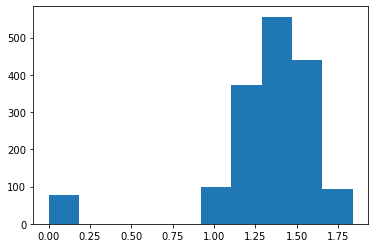

In [14]:
u1, v1, mask = validation.sig2noise_val( u0, v0, 
                                        sig2noise, 
                                        threshold = 1.05 )
plt.hist(sig2noise.flatten())
# if you need more detailed look, first create a histogram of sig2noise
# plt.hist(sig2noise.flatten())
# to see where is a reasonable limit

In [15]:
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u1, v1, 
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)


In [16]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = scaling_factor )


In [17]:
#save in the simple ASCII table format
tools.save(x, y, u3, v3, sig2noise, mask, folder + '/Vector_field/exp1_' + image_number + '.txt' )

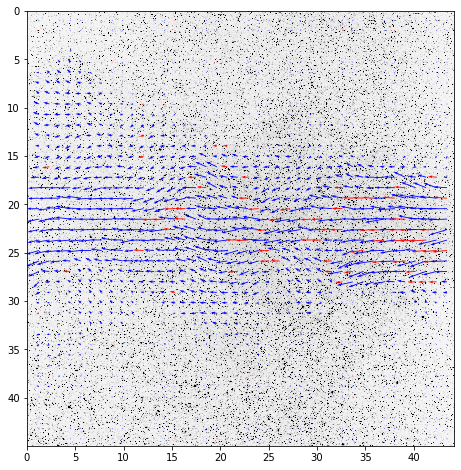

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field( folder + '/Vector_field/exp1_' + image_number + '.txt', 
                           ax=ax, scaling_factor=scaling_factor, 
                           scale= 100, # scale defines here the arrow length
                           width= 0.002, # width is the thickness of the arrow
                           on_img= True, # overlay on the image
                           image_name= folder + '/Images/A' + image_number + 'a.tif');